# Classification of 2D-Data with Keras
This is a simple classification example which was constructed by modifying the Keras example https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py from using MNIST data to easier visualizable 2D-data.

![keras2D.png](./keras2D.png)
The actual network definition is only 6 lines of code. One can see from this how nicely Keras abstracts from the lower-level frontend (tensorflow in this case). Most of the code below is actually concerned with data generation and visualization of the training results. Thanks to numpy and matplotlib also this can be formulated quite compactly.

In [1]:
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


## Generate some training and test data
### Generator for d-dimensional Gaussian data

In [2]:
def getGaussianData(n,d=2,sig=1,mean=None):
    """return n data points from a Gaussian with given variance and mean"""
    if mean is None:
        mean=np.zeros(d)
    cov=np.identity(d)*sig # symmetric
    return np.random.multivariate_normal(mean, cov, n)

### Create multi-class data with several clusters per class

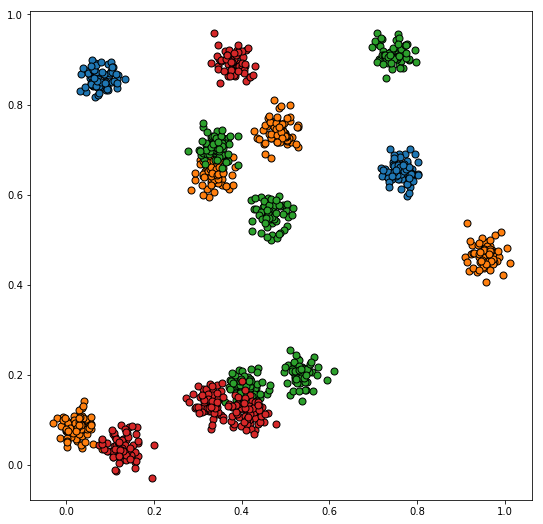

In [3]:
num_classes=5
num_clusters=num_classes*3
# generate some Gaussians belonging to a smalle number of classes
X=[getGaussianData(n=100,d=2,sig=0.0005,mean=np.random.random(2)) 
   for i in range(num_clusters)]
y=[np.full(len(C), np.random.randint(num_classes)) for C in X]

# concatenate
X=np.concatenate(X)
y=np.concatenate(y)

# shuffle consistently
X, y = shuffle(X, y, random_state=0)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33)

y_test_orig = np.copy(y_test)

# plot
fig,ax =plt.subplots(figsize=(9,9))
for i in range(num_classes):
    s = X_train[y_train==i]
    ax.plot(s[:,0],s[:,1],"o",ms=7, markeredgecolor='black',
         markeredgewidth=1)


## one-hot encode output labels

In [4]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## define network and train it

In [5]:
batch_size = 128
epochs = 200
l1=50
l2=50
model = Sequential()
model.add(Dense(l1, activation='relu', input_shape=(2,)))
model.add(Dropout(0.2))
model.add(Dense(l2, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                150       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 255       
Total params: 2,955
Trainable params: 2,955
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.258632856698
Test accuracy: 0.907070707071


## Use trained network to predict classes for whole unit square
(data shown is the test set)

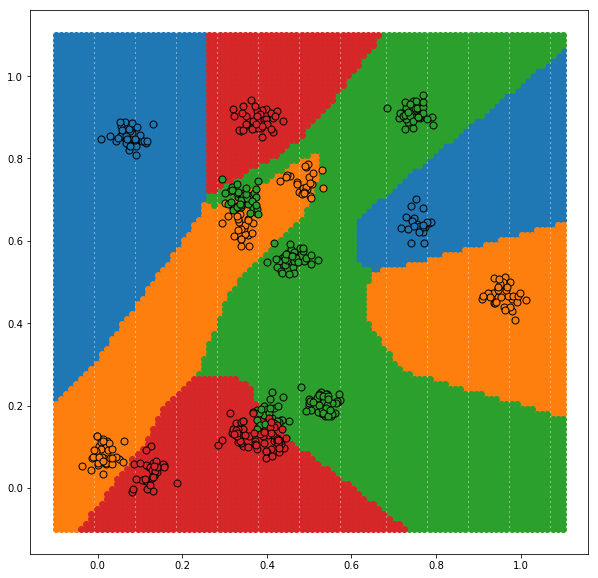

In [6]:
def getGrid(n=100,rim=0.1):
    """generate quadratic gridover unit square plus rim"""
    nx,ny= (n,n)
    x=np.linspace(-rim,1+rim,nx)
    y=np.linspace(-rim,1+rim,ny)
    xv,yv=np.meshgrid(x,y)
    return np.array([a for a in zip(xv.flat,yv.flat)])

G=getGrid()

pred=model.predict(G)
pred = np.argmax(pred,axis=1)

# plot prediction and training data
fig,ax =plt.subplots(figsize=(10,10))
for i in range(num_classes):
    s = G[pred==i]
    ax.plot(s[:,0],s[:,1],".",ms=12)
plt.gca().set_prop_cycle(None)
for i in range(num_classes):
    s = X_test[y_test_orig==i]
    ax.plot(s[:,0],s[:,1],"o",ms=7, markeredgecolor='black',
         markeredgewidth=1)